[Link to colab](https://colab.research.google.com/github/lsmin0152/cheb301/blob/main/notebooks/CHEB301_F25_11_Kfold.ipynb)
## **Demonstration of K-fold Cross-Validation**

*Cross-validation* is a technique that is used to mitigate overfitting, which has a tendency to prevent effective generalizability. Another application of cross-validation is to allow for less biased reporting of results (as opposed to a simple train/test split). In this notebook, we will illustrate the basic mechanics of using `scikit-learn` to generate folds of data. You may want to examine `sklearn`'s [documentation](https://scikit-learn.org/stable/modules/cross_validation.html) for additional support.

In [1]:
# load modules
import numpy as np
from sklearn.model_selection import KFold
import pandas as pd
import urllib.request
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
from scipy.stats import sem as stderr

## **Data Description**

We are going to use the same data from intrinsically disordered proteins as used in prior lectures on linear regression/gradient descent. Recall the inputs are essentially sequences of intrinsically disordered proteins, while there are a few different possible outputs (radius of gyration, heat capacity, relaxation time). We have just been using radius of gyration. If you want to spice things up a little, maybe you can consider using a different label.

In [15]:
url_for_labels    = "https://raw.githubusercontent.com/lsmin0152/cheb301/refs/heads/main/notebooks/data/labels.csv"
url_for_sequences = "https://raw.githubusercontent.com/lsmin0152/cheb301/refs/heads/main/notebooks/data/sequences.txt"
idpdata = pd.read_csv(
    url_for_labels
)

y = idpdata['ROG (A)'].to_numpy()/10.     # these are now labels
seqs  = [line.strip().split() for line in urllib.request.urlopen(url_for_sequences)]
X     = np.array([[1,len(seq),len(seq),len(seq),len(seq)] for seq in seqs])   # these are features
X[:,1]  = X[:,1]**0.5
X[:,2]  = X[:,2]**(2./3)
X[:,-1] = X[:,-1]**2
# The input now looks like x_i = [1, Ni^(1/2),Ni^(2/3),Ni,Ni^2]

idpdata.head()

,ROG (A),CV (J/K),TAUS (fs)
0,11.725914,0.444604,36585.162
1,11.912079,0.370302,40234.011
2,11.375047,0.399939,38123.675
3,11.457038,0.407542,34174.561
4,11.509964,0.449730,34279.740


## **Define your task**

Use the following cells to get some sense as to how much data you have and then set parameters accordingly to define the number of folds that will be used as an input to [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html). Let's say that your current objective is to characterize the expected quality of a linear model.

In [3]:
n = X.shape[0]
k = 5
print("We will partition {} data points in {} folds".format(n,k))

We will partition 2585 data points in 5 folds


In [4]:
kf = KFold(n_splits=k,shuffle=True,random_state=42)
ntest = 0
for i,(iTrain,iTest) in enumerate(kf.split(X)):
    print("For Fold {}...".format(i))
    print("Some example indices/labels are: ")
    for (indj,yj) in zip(iTest[:10],y[iTest][:10]):
      print("{:>5d} {:>8.2f}".format(indj,yj))
    ntest += len(iTest)
    print("\n\n")

print(ntest)

For Fold 0...
Some example indices/labels are: 
   29     1.13
   30     1.17
   43     1.11
   44     1.07
   48     1.15
   49     1.20
   51     1.32
   56     1.25
   57     1.10
   67     1.13



For Fold 1...
Some example indices/labels are: 
    8     1.12
   13     1.12
   18     1.15
   20     1.13
   23     1.15
   25     1.16
   32     1.23
   45     1.27
   59     1.14
   63     1.14



For Fold 2...
Some example indices/labels are: 
    2     1.14
    6     1.13
   10     1.14
   15     1.14
   17     1.15
   22     1.17
   26     1.12
   28     1.16
   31     1.15
   37     1.16



For Fold 3...
Some example indices/labels are: 
    0     1.17
    3     1.15
    5     1.29
    7     1.45
    9     1.16
   12     1.16
   14     1.12
   24     1.08
   27     1.08
   33     1.16



For Fold 4...
Some example indices/labels are: 
    1     1.19
    4     1.15
   11     1.14
   16     1.14
   19     1.13
   21     1.20
   34     1.13
   35     1.16
   36     1.23
   38     1.2

## **Model comparison**

OK, now that we have the ability to create folds, let's utilize that for the training and testing of multiple models. Create data structures that allow you to track their performance of some simple linear models.

In [13]:
kf = KFold(n_splits=k,shuffle=True)
r2folds = [0]*k
params  = [0]*k
for i,(iTrain,iTest) in enumerate(kf.split(X)):
    # define train/test splits
    Xtr = X[iTrain,:]
    ytr = y[iTrain]
    Xte = X[iTest,:]
    yte = y[iTest]

    # train a model
    linreg = LinearRegression(fit_intercept=False).fit(Xtr,ytr)

    # make predictions and store results
    ypr        = linreg.predict(Xte)
    r2folds[i] = r2_score(yte,ypr)
    params[i]  = linreg.coef_[:]

r2avg = np.mean(r2folds)
r2err = stderr(r2folds)

print("The expected performance of this linear model is\n r2 = {:>5.3f}+/-{:>5.3f}"\
      .format(r2avg,r2err))

print(r2folds)


The expected performance of this linear model is
 r2 = 0.939+/-0.003
[0.9303866457376644, 0.9375432658276134, 0.9423801484836289, 0.9348383648485525, 0.9507747502080541]


In [16]:
# global specifications on plots
plt.rcParams.update({'font.size': 18,
                     'font.weight' : 'bold',
                     'axes.labelweight': 'bold'})

def plot_raw_data(x,y,c):
  plt.plot(x, y,linestyle="-",\
           color=c)
  plt.ylabel("Radius of Gyration, $R_g$ (nm)")
  plt.xlabel("$N$")
  plt.xlim(0,1e3)
  plt.ylim(0,15)
  ax = plt.gca()
  ax.tick_params(direction='in')
  ax.yaxis.set_ticks_position('both')
  ax.xaxis.set_ticks_position('both')
  return ax



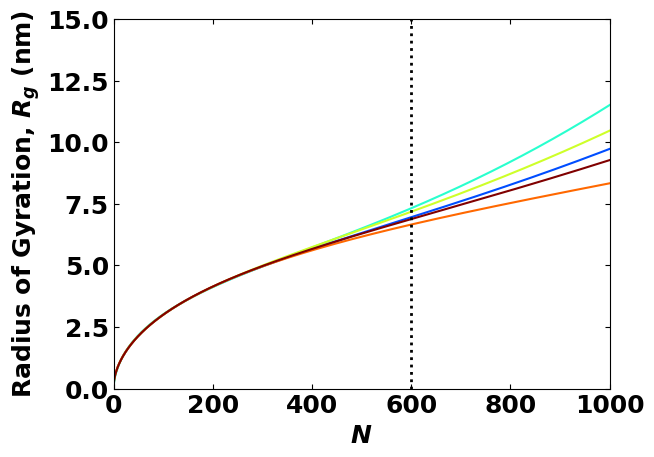

In [17]:
Nrng = np.array([i for i in range(int(5e3))])
Xrng = np.vstack((np.ones(len(Nrng)),Nrng**0.5,Nrng**(2./3),Nrng,Nrng**2)).T
cmap = plt.colormaps['jet']
for i,pari in enumerate(params):
  mod  = LinearRegression().fit(X,y)
  mod.coef_[:] = pari[:]
  yrng = mod.predict(Xrng)
  plot_raw_data(Xrng[:,3],yrng,cmap((i+1)/k))

Nmax = np.max(X[:,3])
plt.plot([Nmax,Nmax],[0,30],'k',linestyle=":",linewidth=2)